# 월마트 고객 구매 패턴 분석
## 분석 목표
다양한 상품군을 구매하는 고객의 특성을 파악하고, 연관 상품 제안 전략 도출

## 분석 흐름
1. 데이터 탐색 및 구매금액 분포 확인
2. 고객별 구매 다양성 산출
3. 다양성 ↔ 구매금액 상관 분석
4. 다양성 높은 고객 프로파일링
5. 상품 조합 분석 (연관 규칙)
6. 마케팅 전략 제안

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'Gulim'
rcParams['axes.unicode_minus'] = False

In [17]:
df = pd.read_csv('walmart.csv')
df.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,7871


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


## 데이터 구조 및 변수 요약

- 전체 데이터는 총 550,068행 × 10개 열로 구성되어 있으며 누락된 값은 존재하지 않음.
- 주요 변수 유형은 다음과 같음:
  - 범주형: Gender, Age, City_Category, Stay_In_Current_City_Years, Marital_Status
  - 수치형: Purchase, Occupation, Product_Category
  - 식별자: User_ID, Product_ID

분석을 시작하기에 앞서 전체 고객의 구매 금액 분포를 확인해 소비 규모의 전반적인 특성과 이상값 여부를 점검하였다.

In [18]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,23961.000000


- 전체 수치형 변수 중 핵심 분석 대상은 Purchase (구매 금액) 변수.
- 평균 구매 금액은 약 9270이며 중앙값은 약 8047로 평균보다 낮아 상위 금액에 치우친 분포로 판단.
- 최댓값은 23961로 일부 고객은 매우 고가의 상품을 구매한 것으로 보임.
- 제1사분위수(Q1)는 5823, 제3사분위수(Q3)는 12054로 대부분의 고객이 약 6천~1만 2천 사이 금액을 지출한 것으로 해석.

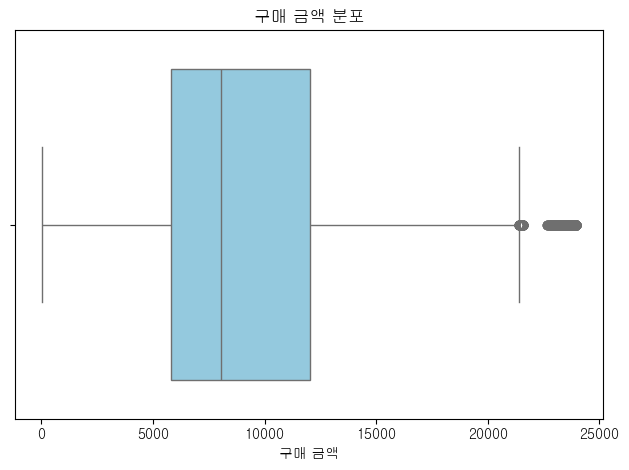

In [60]:
plt.figure()
sns.boxplot(x=df['Purchase'], color='skyblue')
plt.title('구매 금액 분포')
plt.xlabel('구매 금액')
plt.tight_layout()
plt.show()

일부 고객은 20,000원 이상 고액 상품을 구매한 것으로 나타났다.    
중앙값은 약 8,000원 선이며 다수 고객은 5,000원~15,000원 사이에서 구매 활동을 하는 것으로 보인다.

| 변수명                          | 변수 타입          | 설명            | 비고                    |
| ---------------------------- | -------------- | ------------- | --------------------- |
| `User_ID`                    | 범주형            | 고객 ID       | 고객별 그룹 분석에 사용         |
| `Product_ID`                 | 범주형            | 상품 ID       | 상품별 구매 분석 가능          |
| `Gender`                     | 범주형            | 성별            | 이진               |
| `Age`                        | 범주형            | 연령 구간         | 구간 ('26-35'), 55+ 등 문자열  |
| `Occupation`                 | 범주형 | 직업 코드         | 값은 숫자지만 범주형으로 간주 (연산의미 x)|
| `City_Category`              | 범주형            | 도시 구분 (A/B/C) |            -           |
| `Stay_In_Current_City_Years` | 범주형            | 현재 도시 거주 기간   |  문자열이 있음   (4+)     |
| `Marital_Status`             | 범주형            | 결혼 여부 (0/1)   |            -           |
| `Product_Category`           | 범주형            | 상품 카테고리 코드    |          연산의미 x          |
| `Purchase`                   | 수치형            | 구매 금액         |       -   |


구매한 상품 카테고리의 다양성에 주목하여 다양한 상품을 구매한 고객들의 특성을 보다 구체적으로 탐색하고자 한다.

In [9]:
# 고객별로 구매한 상품군 종류 수
diversity = df.groupby('User_ID')['Product_Category'].nunique()
diversity.describe()

count    5891.000000
mean        9.638771
std         3.595397
min         1.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        19.000000
Name: Product_Category, dtype: float64

평균적으로 9.638771 개의 상품군을 구매   
가장 다양하게 산 고객은 19개의 상품군 구매 (max)   

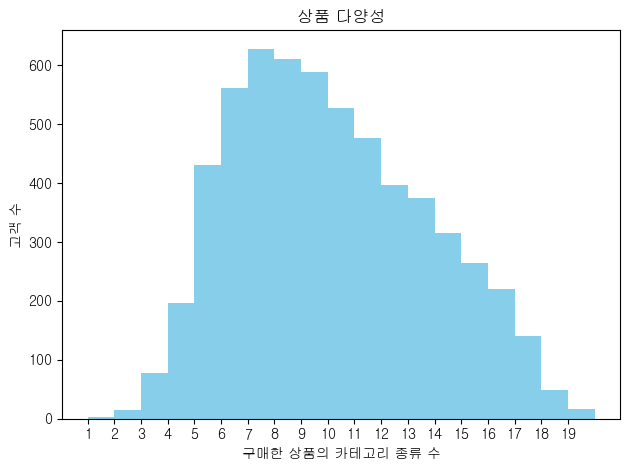

In [19]:
plt.figure()
plt.hist(diversity, bins=range(1, diversity.max()+2), color='skyblue')
plt.title('상품 다양성')
plt.xlabel('구매한 상품의 카테고리 종류 수')
plt.ylabel('고객 수')
plt.xticks(range(1, diversity.max()+1))
plt.tight_layout()
plt.show()

고객별로 구매한 상품 카테고리 수를 집계하여 확인한 결과:    
대부분의 고객이 평균적으로 6~10개 정도의 다양한 상품군을 구매하고 있는 것으로 나타났다.  
최대 19개까지의 상품군을 구매한 고객도 확인되었으며  
이는 고객들이 특정 카테고리에만 집중하기보다는  
다양한 제품군에 관심을 가지고 있다는 점을 보여준다.

-> 상품 다양성이 높은 고객은 연관 상품 제안 기획전 추천 등 마케팅 전략의 주요 타겟이 될 수 있다.   
(한 번에 다양한 상품을 산 건지는 모르지만 다양한 카테고리를 구매했다는 점에서 관심사 범위가 넓은 고객이라고 판단할 수 있다.)   
한번에 샀는지는 구매일자 같은 데이터가 있다면 분석이 가능할 것 같다.   

# 분석 주제: 다양한 상품을 구매한 고객을 타겟으로 한 연관 상품 제안 전략

## 분석 개요

데이터를 살펴보니, 고객마다 구매한 상품 종류가 꽤 다양하다는 걸 알 수 있었다.  
단순히 많이 산 사람보다 여러 카테고리의 상품을 구매한 사람은   
관심사도 넓고 다른 상품에도 반응할 가능성이 높을 거라고 생각했다.  

그래서 이번 분석에서는 상품군 다양성이 높은 고객들을 중심으로   
이들이 어떤 특성을 가지고 있는지 살펴보고   
비슷한 성향의 고객에게 어떤 상품을 추가로 제안할 수 있을지 고민해보려고 한다.   

## 분석 목표
- 고객별로 구매한 상품 카테고리 종류 수 계산 -> 다양한 상품을 산 고객 추출   
- 이 고객들의 성별, 연령대, 직업, 도시 분포 등 특성 분석   
- 여러 상품을 구매한 고객들이 많이 산 상품군을 바탕으로  
  다른 고객에게도 연관 상품을 제안할 수 있는 전략 도출
- 연관 구매 패턴을 바탕으로 묶음 상품 제안 등 실질적인 마케팅 전략 도출

In [21]:
diverse_users = diversity[diversity >= 15].index.tolist()
vip_df = df[df['User_ID'].isin(diverse_users)]

15개의 상품군 이상을 구매한 고객들의 dataframe을 따로 만들기   
-> 히스토그램과 3분위수를 보았을 때 전체 고객의 75%가 12개 이하의 상품군을 구매했음을 알 수 있고    
    15개 이상을 구매한 고객은 상위 약 5~10% 수준에 해당한다고 보았다.

In [22]:
vip_df

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
164,1000033,P00285442,M,46-50,3,A,1,1,8,7854
165,1000033,P00111742,M,46-50,3,A,1,1,15,17391
166,1000033,P00293742,M,46-50,3,A,1,1,8,6074
167,1000033,P00032842,M,46-50,3,A,1,1,8,6119
168,1000033,P00216142,M,46-50,3,A,1,1,1,15333
...,...,...,...,...,...,...,...,...,...,...
550039,1005996,P00371644,F,26-35,0,B,1,1,20,595
550041,1006000,P00371644,M,46-50,17,B,2,1,20,488
550042,1006002,P00371644,M,51-55,0,C,1,1,20,243
550052,1006016,P00375436,M,46-50,1,B,1,1,20,239


In [27]:
new_vip_df = vip_df.drop_duplicates('User_ID')[['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Marital_Status']]
new_vip_df.shape

(692, 6)

In [28]:
new_vip_df.head()

,User_ID,Gender,Age,Occupation,City_Category,Marital_Status
164,1000033,M,46-50,3,A,1
196,1000036,M,26-35,3,B,0
264,1000048,M,26-35,4,B,1
304,1000053,M,26-35,0,B,0
355,1000059,F,51-55,1,B,1


상관계수: 0.73


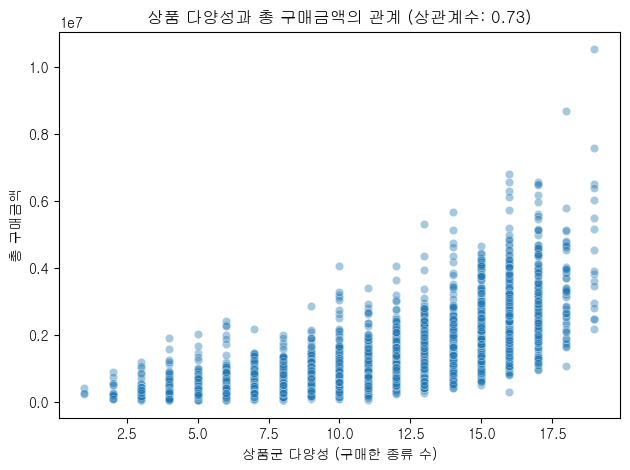

In [64]:
# 고객별 상품 다양성 계산
diversity = df.groupby('User_ID')['Product_Category'].nunique()

# 고객별 총 구매금액 계산
total_purchase = df.groupby('User_ID')['Purchase'].sum()

# 하나의 데이터프레임으로 결합
diversity_df = pd.DataFrame({
    'Diversity': diversity,
    'Total_Purchase': total_purchase
})

# 상관계수 계산
correlation = diversity_df.corr().loc['Diversity', 'Total_Purchase']
print(f"상관계수: {correlation:.2f}")


plt.figure()
sns.scatterplot(data=diversity_df, x='Diversity', y='Total_Purchase', alpha=0.4)
plt.title(f'상품 다양성과 총 구매금액의 관계 (상관계수: {correlation:.2f})')
plt.xlabel('상품군 다양성 (구매한 종류 수)')
plt.ylabel('총 구매금액')
plt.tight_layout()
plt.show()

0.7 이상은 일반적으로 강한 상관관계(strong correlation)로 분류된다.   
이는 상품군 다양성이 클수록 구매금액도 높은 경향이 있다는 것을 의미한다.

다양한 상품을 구매하는 고객일수록 구매 여력과 소비 관심이 높을 가능성을 보여주며   
이들을 대상으로 한 맞춤 추천 및 묶음 기획전은 매출 상승과 재구매 유도에 효과적일 수 있다.

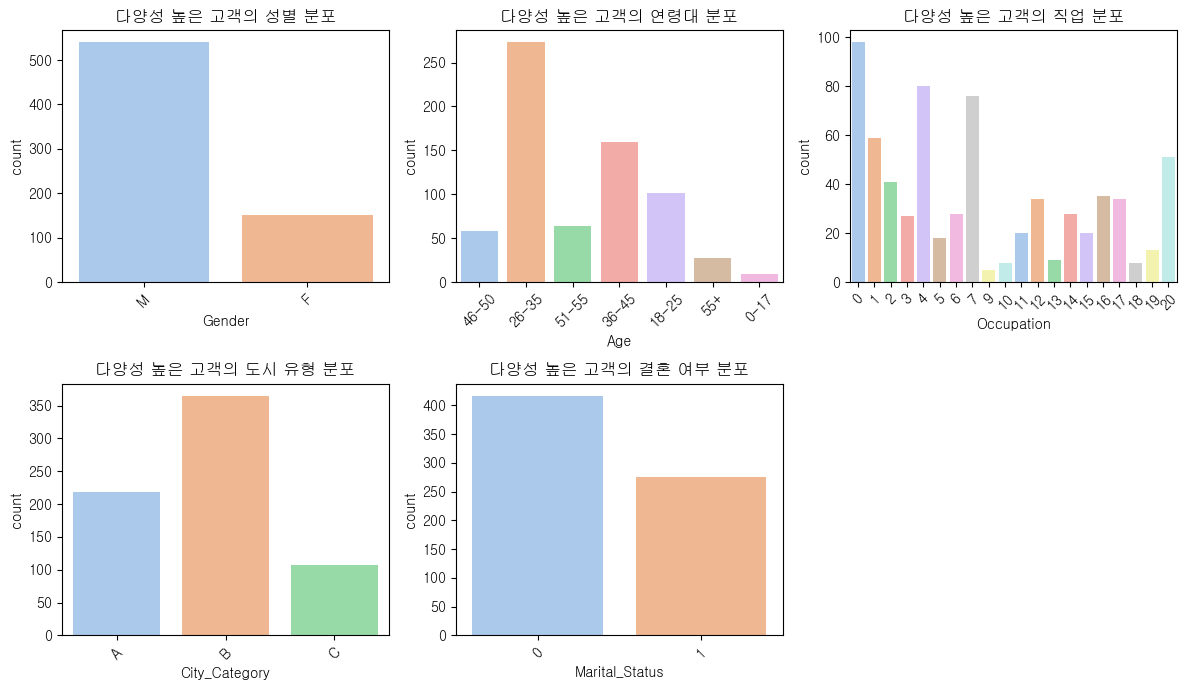

In [38]:
cols = ['Gender', 'Age', 'Occupation', 'City_Category', 'Marital_Status']
titles = ['성별', '연령대', '직업', '도시 유형', '결혼 여부']

plt.figure(figsize=(12, 7))

for i, col in enumerate(cols):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=new_vip_df, x=col, palette='pastel')
    plt.title(f'다양성 높은 고객의 {titles[i]} 분포')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 다양성 높은 고객 특성 요약

- **성별 분포**  
  남성이 여성보다 약 3~4배가량 많았으며 다양한 상품군을 구매하는 고객 중 **대부분이 남성**이었다.

- **연령대 분포**  
  26-35세가 압도적으로 많았고 그 뒤를 36-45세와 18-25세가 이었다.  
  전체적으로 20~40대의 연령대가 중심이었다.

- **직업 분포**  
  직업 분포는 다양한 편이지만 0, 4, 7, 20번 직업군에서 상대적으로 많은 고객이 나타났다.  
  -> 어떤 직업군이 어떤 구매 성향을 보이는지 추가 탐색 가능성 있음.

- **도시 유형**  
  B도시 고객 비중이 가장 많았고 A, C 순으로 나타났다.  
  -> B지역은 유통 중심지 또는 대도시 가능성이 있음.

- **결혼 여부**  
  미혼(0)의 비율이 높았지만 기혼자(1)도 일정 비중을 차지했다.  
  -> 결혼 여부에 따라 상품군 다양성에 뚜렷한 차이는 나타나지 않았다.


## 다양성 높은 고객 데이터에서 상품군 분포 확인

In [39]:
# 다양성 높은 고객의 구매 기록 = vip_df
# 상품 카테고리별 구매 횟수
category_counts = vip_df['Product_Category'].value_counts().sort_values(ascending=False)

top10_categories = category_counts.head(10)
top10_categories

Product_Category
5     54411
8     45577
1     44760
11     9500
2      8931
6      7528
3      6713
4      4257
16     4219
15     2522
Name: count, dtype: int64

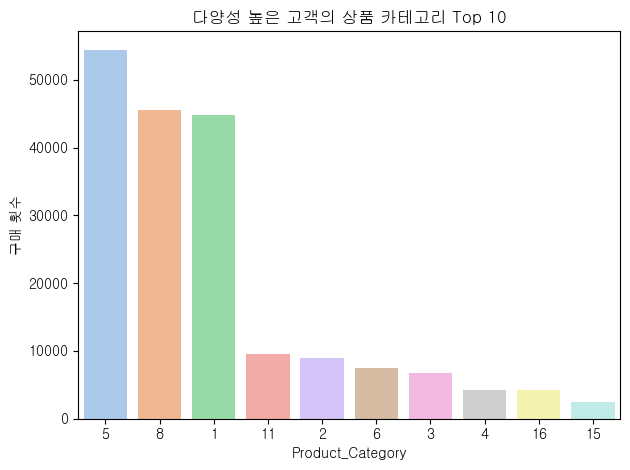

In [41]:
plt.figure()
sns.barplot(x=top10_categories.index.astype(str), y=top10_categories.values, palette='pastel')
plt.title('다양성 높은 고객의 상품 카테고리 Top 10')
plt.xlabel('Product_Category')
plt.ylabel('구매 횟수')
plt.tight_layout()
plt.show()

from itertools import combinations   
여러 개의 항목 중에서 조합(combination)을 만들어주는 함수   
각 고객이 산 상품군 중에서 2개씩 묶은 조합을 찾기 위해 사용   
→ 어떤 상품군들이 함께 자주 구매되었는지 확인하려고!


In [58]:
from itertools import combinations
from collections import Counter

# 다양성이 높은 고객들의 구매내역에서 상품군 집합 추출
vip_sets = vip_df.groupby('User_ID')['Product_Category'].apply(lambda x: set(x))

# 상품군 조합을 모두 뽑아서 카운트
pairs = []
for cat_set in vip_sets:
    for pair in combinations(sorted(cat_set), 2):
        pairs.append(pair)

pair_counts = Counter(pairs)

# 가장 많이 등장한 상위 상품군 조합 10개 추출
top_pairs = pair_counts.most_common(10)
top_pairs

[((1, 5), 692),
 ((1, 6), 692),
 ((1, 8), 692),
 ((5, 6), 692),
 ((5, 8), 692),
 ((6, 8), 692),
 ((1, 2), 690),
 ((2, 5), 690),
 ((2, 6), 690),
 ((2, 8), 690)]

- 1번, 5번 상품군을 함께 구매한 고객 수: 692명
- 5번, 8번 상품군도 692명
- ...   

-> 즉 1-5-8 상품군 조합이 굉장히 강하게 연결되어 있음, 연관 상품 기획에 매우 유의미한 힌트!



In [56]:
# 상위 10개 조합을 DataFrame으로 변환
top_pairs_df = pd.DataFrame(top_pairs, columns=['Product_Pair', 'Count'])
top_pairs_df[['Category_1', 'Category_2']] = pd.DataFrame(top_pairs_df['Product_Pair'].tolist(), index=top_pairs_df.index)
top_pairs_df = top_pairs_df[['Category_1', 'Category_2', 'Count']]
top_pairs_df

,Category_1,Category_2,Count
0,1,5,692
1,1,6,692
2,1,8,692
3,5,6,692
4,5,8,692
5,6,8,692
6,1,2,690
7,2,5,690
8,2,6,690
9,2,8,690


In [57]:
top_pairs_df['카테고리 조합'] = top_pairs_df.apply(
    lambda row: f"Product_Category {row['Category_1']} + Product_Category {row['Category_2']}", axis=1
)

new_top_pairs_df = top_pairs_df[['카테고리 조합', 'Count']]
new_top_pairs_df.columns = ['카테고리 조합', '구매 횟수']

new_top_pairs_df

,카테고리 조합,구매 횟수
0,Product_Category 1 + Product_Category 5,692
1,Product_Category 1 + Product_Category 6,692
2,Product_Category 1 + Product_Category 8,692
3,Product_Category 5 + Product_Category 6,692
4,Product_Category 5 + Product_Category 8,692
5,Product_Category 6 + Product_Category 8,692
6,Product_Category 1 + Product_Category 2,690
7,Product_Category 2 + Product_Category 5,690
8,Product_Category 2 + Product_Category 6,690
9,Product_Category 2 + Product_Category 8,690


## 핵심 요약
Product_Category 1, 5, 6, 8번 상품군은 서로 자주 함께 구매되는 경향을 보인다.
이는 특정 고객층이 일정한 소비 패턴을 가지고 있으며 연관된 상품을 함께 구매하는 성향을 지닌다는 것을 의미한다.

이러한 상품군 조합은 크로스셀 전략에 적합한 구조로 이를 활용하면 고객당 평균 구매 금액을 높이고 재구매를 유도할 수 있는 기반이 된다.



# 마케팅 전략 제안
1. 묶음 상품 기획   
카테고리 1+5 / 5+8 / 1+8과 같은 조합을 기반으로 패키지 상품 또는 할인 전략을 제안한다.   
상품을 다양하게 구매하는 고객에게는 선택형 패키지 추천 시스템을 도입하여 구매의 유연성을 높일 수 있다.   

2. 고객 맞춤형 테마 구성   
연령, 직업, 도시 등 고객 특성을 기반으로 라이프스타일 맞춤 테마 기획전을 구성할 수 있다.   
예: 2030 직장인을 위한 직장인 라이프 세트나 1인 가구 대상의 혼라이프 추천템 등   

3. 상품 추천 시스템 개선   
상위 카테고리 조합 데이터를 기반으로 연관 상품 추천 알고리즘을 개선할 수 있다.   
이를 통해 일반 고객에게도 자연스럽게 추가 상품을 노출시키며 구매 유도 흐름을 강화할 수 있다.   

## 핵심 결론
상품 다양성이 높은 고객(상위 10%)은 총 구매금액도 높으며(r=0.73),
카테고리 1+5+8 조합 묶음 상품 전략이 매출 상승에 효과적일 수 있다.